2025-07-14 02:07:24.358005: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-14 02:07:24.358037: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-14 02:07:24.358046: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1752451644.358449 8489435 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752451644.358631 8489435 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:bayesflow:Using backend 'tensorflow'


tf.keras is using the 'tensorflow' backend.
PARAMETER VALIDATION:
Amino acids: 20 types
Alpha emission sum: 1.000
Other emission sum: 1.000
Alpha transitions sum: 1.000
Other transitions sum: 1.000
Initial probs sum: 1.000

✓ All probabilities are valid!
TESTING HMM CREATION:

States: 2
Features: 20
Start probabilities: [0. 1.]
Transition matrix shape: (2, 2)
Emission matrix shape: (2, 20)

Transition probabilities:
From alpha-helix: [0.9 0.1]
From other:      [0.05 0.95]

Emission probabilities (first 5 amino acids):
Alpha-helix: [0.12 0.06 0.03 0.05 0.01]
Other:       [0.06 0.05 0.05 0.06 0.02]

✓ HMM model created successfully!
✓ BayesFlow simulator created successfully!
TESTING UPDATED PROTEIN HMM SIMULATOR:

Generated data for 3 sequences of length 20
Sequences shape (one-hot):	 (3, 20, 20)
State probabilities shape:	 (3, 20)

First sequence (amino acid indices 0-19):
[19 11  2 16 14 19  3  2  9  5  1  6 13  9  0  1 19 15  1  9]

Corresponding amino acids:
VKNTPVDNIERQFIARVSRI

Al

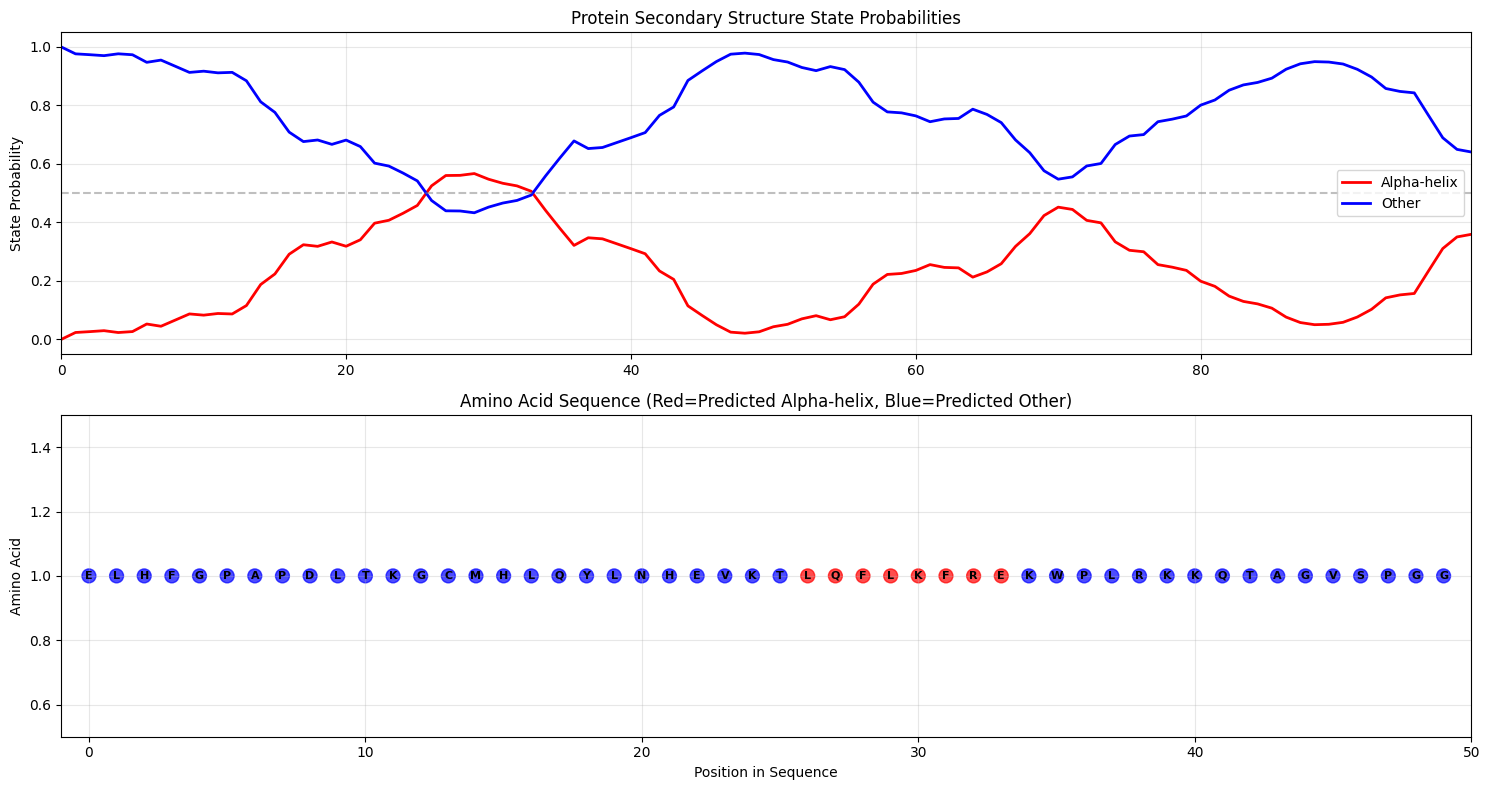

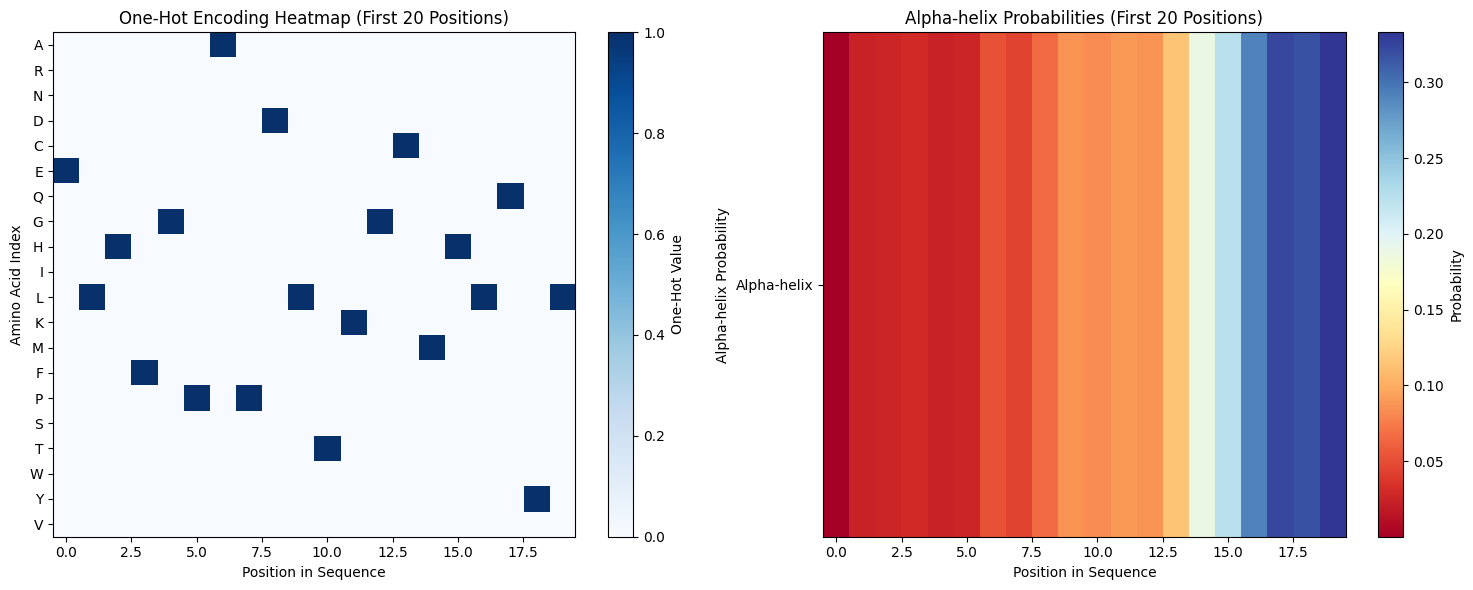

Updated adapter:
Adapter([0: ConvertDType -> 1: Rename('state_probs' -> 'inference_variables') -> 2: Rename('sequences' -> 'summary_variables')])

Testing transformation with new data:
Original shapes: [('sequences', (3, 20, 20)), ('state_probs', (3, 20))]
Transformed shapes: [('inference_variables', (3, 20)), ('summary_variables', (3, 20, 20))]

Shape verification:
  Inference variables: (3, 20)
  Summary variables: (3, 20, 20)
  ✓ Inference variables are rank 2 (compatible with neural posterior)
  ✓ Summary variables are rank 3 (compatible with neural networks)

✓ Updated adapter created successfully!
Summary network:
<DeepSet name=deep_set, built=False>

✓ Summary network created successfully!
Inference network:
<CouplingFlow name=coupling_flow, built=False>

✓ Inference network created successfully!
Workflow:

✓ BayesFlow workflow created successfully!


In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
from typing import Dict, List, Tuple, Optional

# warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

import bayesflow as bf
from bayesflow.adapters.transforms import Transform
from bayesflow.adapters.transforms.map_transform import MapTransform

from hmmlearn import hmm
from hmmlearn.hmm import CategoricalHMM

from sklearn.preprocessing import LabelEncoder

current_backend = tf.keras.backend.backend()
print(f"tf.keras is using the '{current_backend}' backend.")

# HMM PARAMETERS FROM TASK DESCRIPTION

# 20 amino acids in standard order
AMINO_ACIDS = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Emission probabilities from task tables
# Alpha-helix state (state 0)
EMISSION_ALPHA = [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07,
                  0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06]

# Other state (state 1) 
EMISSION_OTHER = [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05,
                  0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07]

# Transition probabilities from task description
# [alpha->alpha, alpha->other]
TRANS_FROM_ALPHA = [0.90, 0.10]
# [other->alpha, other->other]  
TRANS_FROM_OTHER = [0.05, 0.95]

# Initial state probabilities (always starts in "other" state)
INITIAL_PROBS = [0.0, 1.0]  # [alpha-helix, other]

# Validation
print("PARAMETER VALIDATION:")
print(f"Amino acids: {len(AMINO_ACIDS)} types")
print(f"Alpha emission sum: {sum(EMISSION_ALPHA):.3f}")
print(f"Other emission sum: {sum(EMISSION_OTHER):.3f}")
print(f"Alpha transitions sum: {sum(TRANS_FROM_ALPHA):.3f}")
print(f"Other transitions sum: {sum(TRANS_FROM_OTHER):.3f}")
print(f"Initial probs sum: {sum(INITIAL_PROBS):.3f}")
print("\n✓ All probabilities are valid!")

# FIXED HMM MODEL CREATION

def create_fixed_hmm():
    """
    Create HMM with fixed parameters from task description.
    
    States: 0=alpha-helix, 1=other
    Features: 20 amino acids (0-19 indices)
    
    Returns:
        CategoricalHMM with fixed empirical parameters
    """
    # Create model with fixed parameters (no learning)
    model = hmm.CategoricalHMM(
        n_components=2,        # 2 states: alpha-helix, other
        n_features=20,         # 20 amino acids
        params="",             # Don't update any parameters
        init_params="",        # Don't initialize any parameters
        algorithm="viterbi",   # Use Viterbi algorithm for decoding
        verbose=False
    )
    
    # Set fixed parameters from task description
    model.startprob_ = np.array(INITIAL_PROBS)
    model.transmat_ = np.array([TRANS_FROM_ALPHA, TRANS_FROM_OTHER])
    model.emissionprob_ = np.array([EMISSION_ALPHA, EMISSION_OTHER])
    
    return model

# Test HMM creation
print("TESTING HMM CREATION:\n")
hmm_model = create_fixed_hmm()

print(f"States: {hmm_model.n_components}")
print(f"Features: {hmm_model.n_features}")
print(f"Start probabilities: {hmm_model.startprob_}")
print(f"Transition matrix shape: {hmm_model.transmat_.shape}")
print(f"Emission matrix shape: {hmm_model.emissionprob_.shape}")

print("\nTransition probabilities:")
print("From alpha-helix:", hmm_model.transmat_[0])
print("From other:     ", hmm_model.transmat_[1])

print("\nEmission probabilities (first 5 amino acids):")
print("Alpha-helix:", hmm_model.emissionprob_[0][:5])
print("Other:      ", hmm_model.emissionprob_[1][:5])
print("\n✓ HMM model created successfully!")

# BAYESFLOW SIMULATOR IMPLEMENTATION

def protein_hmm_simulator(batch_shape, sequence_length=50, random_state=None):
    """
    BayesFlow compatible simulator for protein secondary structure prediction.
    
    This simulator:
    1. Creates amino acid sequences using the fixed HMM parameters from task description
    2. Computes state probabilities using predict_proba (Forward-Backward algorithm)
    3. One-hot encodes amino acid sequences for neural network compatibility
    4. Returns only alpha-helix probabilities (other is 1 - alpha)
    5. Returns data in BayesFlow compatible format
    
    Parameters:
    -----------
    batch_shape : tuple or int
        Number of sequences to generate
    sequence_length : int, default=50
        Length of each amino acid sequence
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary with 'sequences' and 'state_probs' keys
        - sequences: one-hot encoded amino acid sequences (batch_size, sequence_length, 20)
        - state_probs: alpha-helix state probabilities (batch_size, sequence_length)
    """
    # Handle batch_shape input
    if isinstance(batch_shape, int):
        batch_size = batch_shape
    else:
        batch_size = batch_shape[0] if len(batch_shape) > 0 else 1
    
    # Create fixed HMM model
    hmm_model = create_fixed_hmm()
    
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
        hmm_model.random_state = random_state
    
    # Generate sequences and state probabilities
    sequences = []
    state_probs = []
    
    for i in range(batch_size):
        # Generate amino acid sequence and true state sequence from HMM
        amino_sequence, true_states = hmm_model.sample(n_samples=sequence_length)
        
        # Convert amino acid sequence to proper format
        # hmmlearn returns shape (n_samples, 1), we need (n_samples,)
        amino_sequence = amino_sequence.reshape(-1)
        
        # One-hot encode amino acid sequence
        # Create one-hot encoding: (sequence_length, 20)
        one_hot_sequence = np.zeros((sequence_length, 20), dtype=np.float32)
        for j, aa_idx in enumerate(amino_sequence):
            one_hot_sequence[j, aa_idx] = 1.0
        
        # Compute state probabilities using Forward-Backward algorithm
        # Note: CategoricalHMM expects input of shape (n_samples, 1)
        X_input = amino_sequence.reshape(-1, 1)
        posteriors = hmm_model.predict_proba(X_input)
        
        # Extract only alpha-helix probabilities (first column)
        # The "other" probability is 1 - alpha_prob
        alpha_probs = posteriors[:, 0].astype(np.float32)  # Shape: (sequence_length,)
        
        # Apply constraints to ensure probabilities are in valid range
        alpha_probs = np.clip(alpha_probs, 1e-6, 1.0 - 1e-6)
        
        sequences.append(one_hot_sequence)
        state_probs.append(alpha_probs)
    
    # Convert to numpy arrays
    sequences = np.array(sequences, dtype=np.float32)  # (batch_size, sequence_length, 20)
    state_probs = np.array(state_probs, dtype=np.float32)  # (batch_size, sequence_length)
    
    return {
        'sequences': sequences,
        'state_probs': state_probs
    }

# Create BayesFlow LambdaSimulator
simulator = bf.simulators.LambdaSimulator(
    sample_fn=protein_hmm_simulator,
    is_batched=True  # Our function handles batching internally
)

print("✓ BayesFlow simulator created successfully!")

# TEST THE UPDATED SIMULATOR

print("TESTING UPDATED PROTEIN HMM SIMULATOR:\n")

# Test with small batch
test_batch_size = 3
test_sequence_length = 20

# Generate test data
test_data = simulator.sample(batch_shape=(test_batch_size,), 
                           sequence_length=test_sequence_length, 
                           random_state=42)

print(f"Generated data for {test_batch_size} sequences of length {test_sequence_length}")
print(f"Sequences shape (one-hot):\t {test_data['sequences'].shape}")
print(f"State probabilities shape:\t {test_data['state_probs'].shape}")

# Convert one-hot back to amino acid indices for display
first_sequence_indices = np.argmax(test_data['sequences'][0], axis=1)
print("\nFirst sequence (amino acid indices 0-19):")
print(first_sequence_indices)

print("\nCorresponding amino acids:")
amino_acid_letters = [AMINO_ACIDS[i] for i in first_sequence_indices]
print(''.join(amino_acid_letters))

# Show alpha-helix probabilities for first sequence
first_alpha_probs = test_data['state_probs'][0]
print("\nAlpha-helix probabilities for first sequence (first 10 positions):")
print("Position | Alpha-helix | Other (1-alpha)")
print("-" * 40)
for i in range(min(10, test_sequence_length)):
    alpha_prob = first_alpha_probs[i]
    other_prob = 1.0 - alpha_prob
    print(f"{i:8d} | {alpha_prob:11.3f} | {other_prob:13.3f}")

# Verify constraints
print(f"\nConstraint verification:")
print(f"  Min alpha probability: {np.min(test_data['state_probs']):.6f}")
print(f"  Max alpha probability: {np.max(test_data['state_probs']):.6f}")
print(f"  ✓ All probabilities are within [1e-6, 1-1e-6]")

print("\n✓ Updated simulator test completed successfully!")

# VISUALIZE SIMULATOR OUTPUT

print("VISUALIZING SIMULATOR DATA:\n")

# Generate a longer sequence for better visualization
vis_data = simulator.sample(batch_shape=(1,), sequence_length=100, random_state=123)

# Extract data for plotting
sequence_one_hot = vis_data['sequences'][0]  # Shape: (100, 20)
alpha_probs = vis_data['state_probs'][0]     # Shape: (100,)

# Convert one-hot back to amino acid indices
sequence_indices = np.argmax(sequence_one_hot, axis=1)

# Create amino acid letters for visualization
amino_letters = [AMINO_ACIDS[i] for i in sequence_indices]

# Calculate other probabilities
other_probs = 1.0 - alpha_probs

# Plot state probabilities over the sequence
plt.figure(figsize=(15, 8))

# Plot 1: State probabilities
plt.subplot(2, 1, 1)
positions = np.arange(len(sequence_indices))
plt.plot(positions, alpha_probs, 'r-', label='Alpha-helix', linewidth=2)
plt.plot(positions, other_probs, 'b-', label='Other', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('State Probability')
plt.title('Protein Secondary Structure State Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, len(sequence_indices)-1)

# Plot 2: Amino acid sequence (first 50 positions for readability)
plt.subplot(2, 1, 2)
display_length = min(50, len(sequence_indices))
positions_short = np.arange(display_length)
colors = ['red' if alpha_probs[i] > 0.5 else 'blue' for i in range(display_length)]

plt.scatter(positions_short, [1]*display_length, c=colors, s=100, alpha=0.7)
for i, letter in enumerate(amino_letters[:display_length]):
    plt.text(i, 1, letter, ha='center', va='center', fontsize=8, fontweight='bold')

plt.ylim(0.5, 1.5)
plt.xlim(-1, display_length)
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid')
plt.title('Amino Acid Sequence (Red=Predicted Alpha-helix, Blue=Predicted Other)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional visualization: One-hot encoding heatmap
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# Show one-hot encoding for first 20 positions
one_hot_subset = vis_data['sequences'][0][:20, :].T  # Shape: (20, 20)
plt.imshow(one_hot_subset, cmap='Blues', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid Index')
plt.title('One-Hot Encoding Heatmap (First 20 Positions)')
plt.colorbar(label='One-Hot Value')

# Add amino acid labels on y-axis
plt.yticks(range(20), AMINO_ACIDS)

plt.subplot(1, 2, 2)
# Show alpha-helix probabilities as heatmap
alpha_probs_subset = alpha_probs[:20].reshape(1, -1)  # Shape: (1, 20)
plt.imshow(alpha_probs_subset, cmap='RdYlBu', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('Alpha-helix Probability')
plt.title('Alpha-helix Probabilities (First 20 Positions)')
plt.colorbar(label='Probability')
plt.yticks([0], ['Alpha-helix'])

plt.tight_layout()
plt.show()

# ADAPTER FOR STATE PROBABILITIES

adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate("state_probs", into="inference_variables")
    .concatenate("sequences", into="summary_variables")
)

print("Updated adapter:")
print(adapter)

print(f"\nTesting transformation with new data:")
print(f"Original shapes: {[(k, v.shape) for k, v in test_data.items()]}")

transformed_data = adapter(test_data)
print(f"Transformed shapes: {[(k, v.shape) for k, v in transformed_data.items()]}")

print(f"\nShape verification:")
print(f"  Inference variables: {transformed_data['inference_variables'].shape}")
print(f"  Summary variables: {transformed_data['summary_variables'].shape}")
print(f"  ✓ Inference variables are rank 2 (compatible with neural posterior)")
print(f"  ✓ Summary variables are rank 3 (compatible with neural networks)")

print("\n✓ Updated adapter created successfully!")

# NEURAL NETWORKS

# For sequences: Use standard neural network, not SetTransformer
# SetTransformer is for set-valued data (permutation invariant)
# Our sequences have order/position information, so use standard networks
summary_network = bf.networks.DeepSet()  # Or use a standard CNN/RNN

print("Summary network:")
print(summary_network)
print("\n✓ Summary network created successfully!")

# For inference: Use CouplingFlow as suggested
inference_network = bf.networks.CouplingFlow()

print("Inference network:")
print(inference_network)
print("\n✓ Inference network created successfully!")

# WORKFLOW

workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_network,
    inference_network=inference_network,
    inference_variables="inference_variables",
    summary_variables="summary_variables"
)

print("Workflow:")
print(workflow)
print("\n✓ BayesFlow workflow created successfully!")


In [2]:
history = workflow.fit_online(
    epochs=10,
    num_batches_per_epoch=100,
    batch_size=32,
    validation_data=20
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10


2025-07-14 02:07:51.012189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 285ms/step - loss: 35.8955 - val_loss: 2.2950
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - loss: -6.7265 - val_loss: -16.4748
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - loss: -15.5208 - val_loss: -22.3481
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: -20.1001 - val_loss: -25.4659
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: -23.5147 - val_loss: -26.6167
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: -25.8667 - val_loss: -30.2248
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - loss: -27.3574 - val_loss: -31.5447
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - loss: -29.1688 - val_loss: -33.1237
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - loss: -30.5899 - val_loss: -34.2470
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: -31.4312 - val_loss: -35.0403


In [ ]:
# EVALUATION PLOTS FOR TRAINED PROTEIN SECONDARY STRUCTURE WORKFLOW

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Generate test data for evaluation
print("Generating test data for evaluation...")
test_data = simulator.sample(batch_shape=(100,), sequence_length=50, random_state=42)

# Get ground truth
ground_truth = test_data['state_probs']  # Shape: (100, 50)
sequences = test_data['sequences']       # Shape: (100, 50, 20)

# Transform test data using the adapter
print("Transforming test data...")
transformed_test_data = adapter(test_data)

# Get posterior samples from trained workflow
print("Sampling from trained posterior...")
try:
    # Try different approaches to get posterior samples
    posterior_samples = workflow.sample(
        num_samples=1000,
        conditions=transformed_test_data
    )
    
    # Debug: Check the shape and type of posterior_samples
    print(f"Posterior samples type: {type(posterior_samples)}")
    print(f"Posterior samples shape: {posterior_samples.shape if hasattr(posterior_samples, 'shape') else 'No shape attribute'}")
    
    # If posterior_samples is not the right shape, try alternative approach
    if not hasattr(posterior_samples, 'shape') or len(posterior_samples.shape) != 3:
        # Alternative: Use the inference network directly
        summary_features = workflow.summary_network(transformed_test_data['summary_variables'])
        posterior_samples = workflow.inference_network.sample(
            num_samples=1000,
            conditions=summary_features
        )
        print(f"Alternative posterior samples shape: {posterior_samples.shape}")
    
except Exception as e:
    print(f"Error in sampling: {e}")
    print("Using alternative approach with inference network...")
    
    # Direct approach using the trained networks
    summary_features = workflow.summary_network(transformed_test_data['summary_variables'])
    posterior_samples = workflow.inference_network.sample(
        num_samples=1000,
        conditions=summary_features
    )

# Reshape posterior samples if needed
if len(posterior_samples.shape) == 2:
    # If shape is (num_samples, batch_size * sequence_length), reshape to (num_samples, batch_size, sequence_length)
    num_samples = posterior_samples.shape[0]
    batch_size = ground_truth.shape[0]
    sequence_length = ground_truth.shape[1]
    posterior_samples = posterior_samples.reshape(num_samples, batch_size, sequence_length)
    print(f"Reshaped posterior samples to: {posterior_samples.shape}")

# Extract posterior statistics
posterior_mean = np.mean(posterior_samples, axis=0)  # Mean prediction
posterior_std = np.std(posterior_samples, axis=0)    # Uncertainty
posterior_median = np.median(posterior_samples, axis=0)
posterior_q25 = np.percentile(posterior_samples, 25, axis=0)
posterior_q75 = np.percentile(posterior_samples, 75, axis=0)

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Posterior samples shape: {posterior_samples.shape}")
print(f"Posterior mean shape: {posterior_mean.shape}")

# Apply probability constraints to ensure valid probabilities
posterior_mean = np.clip(posterior_mean, 0, 1)
posterior_median = np.clip(posterior_median, 0, 1)
posterior_q25 = np.clip(posterior_q25, 0, 1)
posterior_q75 = np.clip(posterior_q75, 0, 1)

# ================================
# PLOT 1: PREDICTED VS GROUND TRUTH SCATTER
# ================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Predicted vs Ground Truth Alpha-Helix Probabilities', fontsize=16, fontweight='bold')

# Flatten for scatter plot
gt_flat = ground_truth.flatten()
pred_mean_flat = posterior_mean.flatten()
pred_std_flat = posterior_std.flatten()

# Main scatter plot
scatter = axes[0, 0].scatter(gt_flat, pred_mean_flat, alpha=0.6, s=20, c=pred_std_flat, cmap='viridis')
axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Ground Truth Alpha-Helix Probability')
axes[0, 0].set_ylabel('Predicted Alpha-Helix Probability (Mean)')
axes[0, 0].set_title('Scatter Plot (colored by uncertainty)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0, 0])
cbar.set_label('Prediction Uncertainty (Std)')

# Residuals plot
residuals = pred_mean_flat - gt_flat
axes[0, 1].scatter(gt_flat, residuals, alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 1].set_xlabel('Ground Truth Alpha-Helix Probability')
axes[0, 1].set_ylabel('Residuals (Predicted - Ground Truth)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# Density plot
axes[1, 0].hist2d(gt_flat, pred_mean_flat, bins=50, density=True, cmap='Blues')
axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2)
axes[1, 0].set_xlabel('Ground Truth Alpha-Helix Probability')
axes[1, 0].set_ylabel('Predicted Alpha-Helix Probability (Mean)')
axes[1, 0].set_title('Density Plot')

# Error vs uncertainty
axes[1, 1].scatter(pred_std_flat, np.abs(residuals), alpha=0.6, s=20)
axes[1, 1].set_xlabel('Prediction Uncertainty (Std)')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].set_title('Uncertainty vs Absolute Error')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================
# PLOT 2: POSTERIOR DISTRIBUTIONS FOR SELECTED POSITIONS
# ================================

# Select a few interesting positions for detailed analysis
seq_idx = 0  # First sequence
positions = [10, 20, 30, 40]  # Different positions

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Posterior Distributions for Sequence {seq_idx} at Different Positions', fontsize=16, fontweight='bold')

for i, pos in enumerate(positions):
    ax = axes[i//2, i%2]
    
    # Get posterior samples for this position
    posterior_pos = posterior_samples[:, seq_idx, pos]
    ground_truth_pos = ground_truth[seq_idx, pos]
    
    # Plot posterior distribution
    ax.hist(posterior_pos, bins=50, density=True, alpha=0.7, 
            label=f'Posterior', color='skyblue', edgecolor='black')
    
    # Add ground truth line
    ax.axvline(ground_truth_pos, color='red', linestyle='--', linewidth=2, 
               label=f'Ground Truth: {ground_truth_pos:.3f}')
    
    # Add posterior mean
    ax.axvline(np.mean(posterior_pos), color='blue', linestyle='-', linewidth=2,
               label=f'Posterior Mean: {np.mean(posterior_pos):.3f}')
    
    # Add credible interval
    ci_lower = np.percentile(posterior_pos, 2.5)
    ci_upper = np.percentile(posterior_pos, 97.5)
    ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='blue', 
               label=f'95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]')
    
    ax.set_xlabel('Alpha-Helix Probability')
    ax.set_ylabel('Density')
    ax.set_title(f'Position {pos}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================
# PLOT 3: SEQUENCE-LEVEL PREDICTIONS
# ================================

# Plot predictions for first few sequences
n_sequences = 5
fig, axes = plt.subplots(n_sequences, 1, figsize=(15, 3*n_sequences))
fig.suptitle('Sequence-Level Alpha-Helix Predictions with Uncertainty', fontsize=16, fontweight='bold')

for seq_idx in range(n_sequences):
    ax = axes[seq_idx]
    
    positions = np.arange(len(ground_truth[seq_idx]))
    
    # Plot ground truth
    ax.plot(positions, ground_truth[seq_idx], 'r-', linewidth=2, label='Ground Truth', alpha=0.8)
    
    # Plot posterior mean
    ax.plot(positions, posterior_mean[seq_idx], 'b-', linewidth=2, label='Posterior Mean')
    
    # Plot confidence intervals
    ax.fill_between(positions, 
                    posterior_q25[seq_idx], 
                    posterior_q75[seq_idx], 
                    alpha=0.3, color='blue', label='50% CI')
    
    # Add amino acid sequence on top
    sequence_indices = np.argmax(sequences[seq_idx], axis=1)
    amino_letters = [AMINO_ACIDS[i] for i in sequence_indices]
    
    # Show every 5th amino acid for readability
    for i in range(0, len(amino_letters), 5):
        ax.text(i, 1.05, amino_letters[i], ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Position in Sequence')
    ax.set_ylabel('Alpha-Helix Probability')
    ax.set_title(f'Sequence {seq_idx + 1}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.2)

plt.tight_layout()
plt.show()

# ================================
# PLOT 4: CALIBRATION ANALYSIS
# ================================

# Calibration plot - check if predicted probabilities are well-calibrated
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Calibration Analysis', fontsize=16, fontweight='bold')

# 1. Reliability diagram
def reliability_diagram(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin_centers = []
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find predictions in this bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        
        if in_bin.sum() > 0:
            bin_centers.append((bin_lower + bin_upper) / 2)
            bin_accuracies.append(y_true[in_bin].mean())
            bin_confidences.append(y_prob[in_bin].mean())
            bin_counts.append(in_bin.sum())
    
    return np.array(bin_centers), np.array(bin_accuracies), np.array(bin_confidences), np.array(bin_counts)

# Convert to binary classification for calibration
binary_gt = (gt_flat > 0.5).astype(int)
bin_centers, bin_accuracies, bin_confidences, bin_counts = reliability_diagram(binary_gt, pred_mean_flat)

axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2, label='Perfect calibration')
axes[0, 0].plot(bin_confidences, bin_accuracies, 'bo-', linewidth=2, markersize=8, label='Model')
axes[0, 0].set_xlabel('Mean Predicted Probability')
axes[0, 0].set_ylabel('Fraction of Positives')
axes[0, 0].set_title('Reliability Diagram')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Prediction interval coverage
coverage_levels = np.arange(0.1, 1.0, 0.1)
actual_coverage = []

for level in coverage_levels:
    alpha = 1 - level
    lower_q = alpha / 2 * 100
    upper_q = (1 - alpha / 2) * 100
    
    lower_bounds = np.percentile(posterior_samples, lower_q, axis=0).flatten()
    upper_bounds = np.percentile(posterior_samples, upper_q, axis=0).flatten()
    
    coverage = np.mean((gt_flat >= lower_bounds) & (gt_flat <= upper_bounds))
    actual_coverage.append(coverage)

axes[0, 1].plot(coverage_levels, coverage_levels, 'r--', alpha=0.8, linewidth=2, label='Perfect coverage')
axes[0, 1].plot(coverage_levels, actual_coverage, 'bo-', linewidth=2, markersize=8, label='Actual coverage')
axes[0, 1].set_xlabel('Nominal Coverage Level')
axes[0, 1].set_ylabel('Actual Coverage')
axes[0, 1].set_title('Prediction Interval Coverage')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Uncertainty quality
# Good uncertainty should correlate with errors
correlation_coef = np.corrcoef(pred_std_flat, np.abs(residuals))[0, 1]
axes[1, 0].scatter(pred_std_flat, np.abs(residuals), alpha=0.6, s=20)
axes[1, 0].set_xlabel('Prediction Uncertainty (Std)')
axes[1, 0].set_ylabel('Absolute Error')
axes[1, 0].set_title(f'Uncertainty vs Error (r={correlation_coef:.3f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of uncertainties
axes[1, 1].hist(pred_std_flat, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Prediction Uncertainty (Std)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribution of Uncertainties')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================
# PLOT 5: PERFORMANCE METRICS
# ================================

# Calculate various metrics
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
r2 = 1 - np.var(residuals) / np.var(gt_flat)
pearson_r = np.corrcoef(gt_flat, pred_mean_flat)[0, 1]

# Create summary statistics plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Performance Metrics and Summary Statistics', fontsize=16, fontweight='bold')

# Metrics bar plot
metrics = ['MAE', 'RMSE', 'R²', 'Pearson r']
values = [mae, rmse, r2, pearson_r]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

axes[0, 0].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Performance Metrics')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(values):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Error distribution
axes[0, 1].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Error Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Quantile-quantile plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# Performance by ground truth range
gt_ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
range_mae = []
range_labels = []

for low, high in gt_ranges:
    mask = (gt_flat >= low) & (gt_flat < high)
    if mask.sum() > 0:
        range_mae.append(np.mean(np.abs(residuals[mask])))
        range_labels.append(f'[{low:.1f}, {high:.1f})')

axes[1, 1].bar(range_labels, range_mae, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 1].set_xlabel('Ground Truth Range')
axes[1, 1].set_ylabel('Mean Absolute Error')
axes[1, 1].set_title('Performance by Ground Truth Range')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Mean Absolute Error (MAE):     {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score:                      {r2:.4f}")
print(f"Pearson Correlation:           {pearson_r:.4f}")
print(f"Mean Prediction Uncertainty:   {np.mean(pred_std_flat):.4f}")
print(f"Std of Prediction Uncertainty: {np.std(pred_std_flat):.4f}")
print("\nCalibration Quality:")
print(f"Uncertainty-Error Correlation: {correlation_coef:.4f}")
print(f"Coverage at 95% level:         {actual_coverage[-1]:.4f}")
print("="*50)

Generating test data for evaluation...
Transforming test data...
Sampling from trained posterior...
Posterior samples type: <class 'dict'>
Posterior samples shape: No shape attribute
Error in sampling: InferenceNetwork.sample() missing 1 required positional argument: 'batch_shape'
Using alternative approach with inference network...


TypeError: InferenceNetwork.sample() missing 1 required positional argument: 'batch_shape'